# MSc in Data Science, AUEB

# Numerical Optimization and Large Scale Linear Algebra, Assignment 4

## Vasileios Ilias Drouzas

## Student ID: f3352301

## Pagerank

In the file *Stanweb.dat*, you will find in compressed form the connectivity matrix
for the webpages of Stanford University. Specifically in the first column are contained
the nodes while in the second the node with which is connected. Using the notation
of the tutorial *pagerank.pdf* do the following:

a) Find the vector *π* with

i) the **Power** method

ii) solving the corresponding system (**Gauss Seidel Method**)


as they are described in paragraph 5.1 and 5.2 of the tutorial. For both methods
consider as **α = 0.85** and stopping criterion **τ = 10−8** and the vector a having **1**
if it is corresponds to a node with no out links and **0** otherwise. Are the results
the same for both methods? Which method seems to be faster?


b) Do the previous task with **α = 0.99**. Your remarks on the convergence speed. Did
the ranking of the first 50 nodes change?

c) When we use the power method do all the cmponents of π converge at the same
speed to their limits? If not which of the converge faster: those that correspond
to important nodes or to non important ? Do you observe the same behavior
when you find *π* through the solution of the linear system?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import csr_matrix
import time
from scipy.sparse import identity
from scipy.sparse.linalg import splu
from tabulate import tabulate


In [2]:
path = 'C:/Users/Drogias/Desktop/MSc Data Science AUEB/2nd semester/Numerical optimization/Assignments/4/project_pagerank/'

data = pd.read_csv(path + 'stanweb.dat', header=None, sep= '\t')

data.head()


,0,1,2
0,1,6548,0.500000
1,1,15409,0.500000
2,2,252915,0.032258
3,2,246897,0.032258
4,2,251658,0.032258


In [3]:
def create_matrix(data):
 

    n = int(data[0].max())
    
    nodes = data[0].astype(int) - 1 
    links = data[1].astype(int) - 1 
    probs = data[2]

    P = csr_matrix((probs, (nodes, links)), shape=(n, n))
    return P

In [4]:
P = create_matrix(data)
P


<281903x281903 sparse matrix of type '<class 'numpy.float64'>'
	with 2312497 stored elements in Compressed Sparse Row format>


### i)  Power method


The function for the power method can be summarized as follows:

- $ x^{(k)T} = \alpha x^{(k-1)T} P + (\alpha x^{(k-1)T} a + (1-\alpha))v^T $

In [5]:
def power_method(P, a, t, max_iterations = 10000):
    
    n2 = P.shape[0]
    x0 = np.ones(P.shape[1]) / n2                 #initial x0 vector
    v = np.ones(P.shape[1]) / n2                 #v^T
    
    row_sums = np.sum(P, axis=1)
    zero_row_indices = np.where(row_sums == 0)[0]       #find dangling nodes
    av = np.zeros(P.shape[0])
    av[zero_row_indices] = 1           #av
    
    
    converged = False
    errors = []
    
    top_20 =  [np.flip((np.argsort(x0.flatten())+1))[:20]]               #initialize top 20 rankings
    bottom_20 = [np.flip((np.argsort(x0.flatten())+1))[-20:]] 
    iterations = 0
    
    while (not converged and iterations < max_iterations):
        x = a * x0 * P + (a * x0 * av + (1 - a)) * v 

        top_20.append(np.flip((np.argsort(x.flatten())+1))[:20])            #update top 20 rankings
        bottom_20.append(np.flip((np.argsort(x.flatten())+1))[-20:])
    
        iterations = iterations + 1
       
        error = np.linalg.norm(x - x0, ord = 2) / np.linalg.norm(x, ord = 2)   #convergence function, using Euclidean norm
        errors.append(error)
        x0 = x
        
        if (error < t):
            print("Method converged!")
            print("Iterations used:", iterations)
            converged = True
            
       
    return x, errors, top_20, bottom_20
    

In [6]:
start_time = time.time()
x_power, errors_power, top20_power, bottom20_power = power_method(P, 0.85, np.power(10.0, -8))
end_time = time.time()
print("Total time:", round(end_time-start_time,3),"sec")

Method converged!
Iterations used: 95
Total time: 4.119 sec


Let's find now the 50 most important nodes.

In [7]:
def get_top_k_nodes(x, k):
    '''Function to return top k nodes'''
    
    top_indices = np.argsort(-x)[:k]
    top = top_indices + 1
    return top

In [8]:
top_50_power = get_top_k_nodes(x_power, 50)
print("Top 50 nodes of x vector:\n", top_50_power)

Top 50 nodes of x vector:
 [ 89073 226411 241454 262860 134832 234704 136821  68889 105607  69358
  67756 225872 186750 251796 272442  95163 119479 231363  55788 167295
 179645  38342 117152 198090  60210 235496 132695 181701 247241 259455
  62478 120708 161890  17781 137632 176790  77999 221087 183004  96745
 112742 145892 151428  81435  60440 208542     91 214128 258348 222873]


### ii)  Gauss Seidel Method.

The Sparse linear formulation of the Pagerank problem is given by:

$$
\pi^T (I - \alpha P) = v^T
$$

where $\pi^T e = 1$.


A system like this can be solved with the Gauss Seidel iterative method. The Gauss Seidel method supports solving for systems of the form **A x = b** ([manual](https://www.robots.ox.ac.uk/~sjrob/Teaching/EngComp/linAlg34.pdf)), where 

$$
A = I - \alpha P
$$

$$
b = v^T
$$

To solve systems like this, we use *LU decomposition* ([manual](https://www.sheffield.ac.uk/media/32074/download?attachment)).

Ax = b ⇒ (LU)x = b ⇒ L(Ux) = b

In [9]:
def forward_substitution(L, b):
    ''' Performs forward substitution to solve the lower triangular system Lx = b'''
    x = L.solve(b)

    return x

In [10]:
def gauss_seidel_linear_system(P, a, t, max_iterations = 10000):
    
    n2 = P.shape[0]
    I = identity(n2)                          #I
    
    A = (I - a * P).T                             #A
  
    b = np.ones(P.shape[1]) / n2                 #v^T
    x0 = np.ones(P.shape[1]) / n2                 #initial x0 vector

   
    lower_A = sparse.tril(A, format='csc')                       #lower triangular part of matrix A

    
    L_lower = splu(lower_A)                   #LU decomposition on the lower triangular part of A
 
    
    
    U_lower = sparse.triu(A, 1, format='csc')     #upper triangular factor from the lower triangular part of A (zeroing out elements below the first diagonal (k=1))
  

    converged = False
    errors = []

    top_20 =  [np.flip((np.argsort(x0.flatten())+1))[:20]] 
    bottom_20 = [np.flip((np.argsort(x0.flatten())+1))[-20:]]
    
    iterations = 0
    while (not converged and iterations < max_iterations):
        Ux = U_lower.dot(x0)
        residual = b - Ux
        x = forward_substitution(L_lower, residual)    #solve for x on Lx = b

        top_20.append(np.flip((np.argsort(x.flatten())+1))[:20])
        bottom_20.append(np.flip((np.argsort(x.flatten())+1))[-20:])
        
        
        iterations = iterations + 1
        error = np.linalg.norm(x - x0, ord = 2) / np.linalg.norm(x, ord = 2)   #convergence function, using Euclidean norm
        errors.append(error)
        x0 = x
        if (error < t):
            print("Method converged!")
            print("Iterations used:", iterations)
            converged = True
    return x,errors,top_20, bottom_20
    
    

In [11]:
start_time = time.time()
x_gauss, errors_gauss, top_20_gauss, bottom_20_gauss = gauss_seidel_linear_system(P, 0.85, np.power(10.0, -8))
end_time = time.time()
print("Total time:", round(end_time-start_time,3),"sec")

Method converged!
Iterations used: 56
Total time: 3.587 sec


In [12]:
top_50_seidel = get_top_k_nodes(x_gauss, 50)
print("Top 50 nodes of x vector:\n", top_50_seidel)

Top 50 nodes of x vector:
 [ 89073 226411 241454 262860 134832 234704 136821  68889 105607  69358
  67756 225872 186750 272442 251796  95163 119479 231363  55788 167295
 179645  38342 117152 198090  60210 235496 132695 181701 259455 247241
 120708  62478 161890 221087 183004 176790 137632  77999  17781  96745
 112742 145892 151428  81435  60440 208542     91 214128 258348 222873]


### Are the results the same for both methods? Which method seems to be faster? 

Let's compare the two arrays of nodes:

In [13]:
def get_common_elements(arr1, arr2):
    '''Returns the number of common elements between 2 arrays'''
    list1 = list(arr1)
    list2 = list(arr2)
    common = []
    
    for elem in list1:
        if elem in list2:
            common.append(elem)
            list2.remove(elem)
            
    num_common_elements = len(common)

    return num_common_elements

In [14]:
num_common = get_common_elements(top_50_power, top_50_seidel)
print("Number of common elements between the 2 arrays of nodes of the two methods:", num_common)

Number of common elements between the 2 arrays of nodes of the two methods: 50


So both methods return the same nodes.

The power method seems to be slower than Gauss Seidel, since it needs more iterations (95, instead of 56 with the linear system) to converge to a solution. Let's plot the errors over iterations:

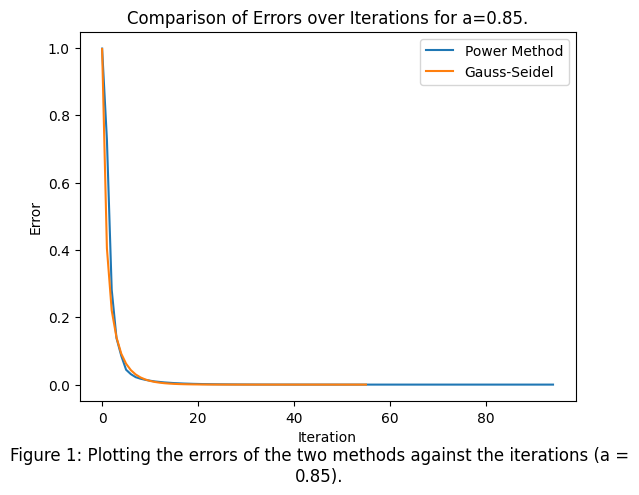

In [15]:
plt.plot(errors_power, label='Power Method')
plt.plot(errors_gauss, label='Gauss-Seidel')


plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Comparison of Errors over Iterations for a=0.85.')
plt.legend()
txt="Figure 1: Plotting the errors of the two methods against the iterations (a = 0.85)."
plt.figtext(0.5, -0.05, txt, wrap=True ,horizontalalignment = 'center', fontsize=12)
plt.show()


In [16]:
print("Final error (Gauss-Seidel):", errors_gauss[-1])
print("Final error (Power Method):", errors_power[-1])


Final error (Gauss-Seidel): 8.813798207866783e-09
Final error (Power Method): 9.444640814815037e-09


Comparing the final errors, we can see that the final error for the Gauss-Seidel method is slightly smaller than that of the Power Method. Therefore, based on the errors alone, the Gauss-Seidel method appears to have converged slightly more accurately in our case. 


b) Do the previous task with **α = 0.99**. Your remarks on the convergence speed. Did
the ranking of the first 50 nodes change?

In [17]:
start_time = time.time()
x_power_2, errors_power_2, top_20_power_2, bottom_20_power_2 = power_method(P, 0.99, np.power(10.0, -8))
end_time = time.time()
print("Total time:", round(end_time-start_time,3),"sec")

Method converged!
Iterations used: 1514
Total time: 65.925 sec


In [18]:
top_50_power_2 = get_top_k_nodes(x_power_2, 50)
print("Top 50 nodes of x vector:\n", top_50_power_2)

Top 50 nodes of x vector:
 [ 89073 281772 174665 226411 179645 271409 262860 136821  68889  77988
 116530 272442  95163 251796  65580 119479 241454 245765  58048  14785
  77084 117152 152337 181701 235496 247241 259455  62478 120708  77999
  17781 183004 176790 137632 221087  96745 119822  27904 272762  96196
  95366 229580 169234 234962 236644  58612  85040 264187 275885  49047]


In [19]:
start_time = time.time()
x_gauss_2, errors_gauss_2, top_20_gauss_2, bottom_20_gauss_2 = gauss_seidel_linear_system(P, 0.99, np.power(10.0, -8))
end_time = time.time()
print("Total time:", round(end_time-start_time,3),"sec")

Method converged!
Iterations used: 770
Total time: 46.221 sec


In [20]:
top_50_seidel_2 = get_top_k_nodes(x_gauss_2, 50)
print("Top 50 nodes of x vector:\n", top_50_seidel_2)

Top 50 nodes of x vector:
 [ 89073 281772 174665 226411 179645 271409 262860 136821  68889  77988
 116530 272442 251796  95163  65580 119479 241454 245765  58048  14785
  77084 117152 152337 181701 235496 259455 247241 120708  62478 221087
 183004 176790 137632  77999  17781  96745 119822  27904 272762  96196
 229580  95366 234962 169234  85040 236644  49047 275885 144494 264187]


In [21]:
num_common2 = get_common_elements(top_50_power_2, top_50_seidel_2)
print("Number of common elements between the 2 arrays of nodes of the two methods:", num_common2)

Number of common elements between the 2 arrays of nodes of the two methods: 49


We notice we have one change here.

*Remarks on the convergence speed*. The total iterations and time needed for each method and alpha is described below:

|  | a = 0.85 | a = 0.99 |
|-----------------|-----------------|-----------------|
| Power method   |  95 iterations (2.302 sec)   | 1514 iterations (36.678 sec)   |
| Gauss Seidel Method    | 56 iterations (2.47 sec)  | 770 iterations (27.305 sec)  |


In [22]:
print("Final error (Gauss-Seidel):", errors_gauss_2[-1])
print("Final error (Power Method):", errors_power_2[-1])


Final error (Gauss-Seidel): 9.918919392910692e-09
Final error (Power Method): 9.93321926652582e-09


The errors are very close here, but we see that still Gauss Seidel method shows a little smaller error rate.

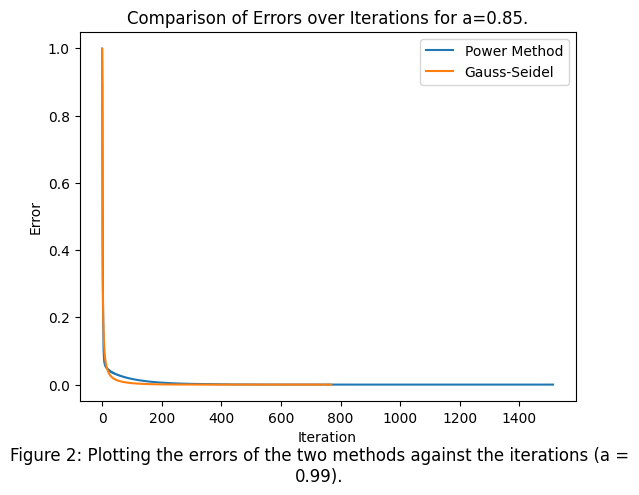

In [23]:
plt.plot(errors_power_2, label='Power Method')
plt.plot(errors_gauss_2, label='Gauss-Seidel')

plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Comparison of Errors over Iterations for a=0.85.')
plt.legend()
txt="Figure 2: Plotting the errors of the two methods against the iterations (a = 0.99)."
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

### Did the ranking of the first 50 nodes change?

In [24]:
df_power_85 = pd.DataFrame({'Power(a=0.85)': top_50_power})
df_seidel_85 = pd.DataFrame({'Gauss-Seidel(a=0.85)': top_50_seidel})
df_power_99 = pd.DataFrame({'Power(a=0.99)': top_50_power_2})
df_seidel_99 = pd.DataFrame({'Gauss-Seidel(a=0.99)': top_50_seidel_2})


df_combined = pd.concat([df_power_85, df_seidel_85, df_power_99, df_seidel_99], axis=1)

print(df_combined)


    Power(a=0.85)  Gauss-Seidel(a=0.85)  Power(a=0.99)  Gauss-Seidel(a=0.99)
0           89073                 89073          89073                 89073
1          226411                226411         281772                281772
2          241454                241454         174665                174665
3          262860                262860         226411                226411
4          134832                134832         179645                179645
5          234704                234704         271409                271409
6          136821                136821         262860                262860
7           68889                 68889         136821                136821
8          105607                105607          68889                 68889
9           69358                 69358          77988                 77988
10          67756                 67756         116530                116530
11         225872                225872         272442                272442

For the first rows, Power method and Gauss-Seidel method in the same alpha level return similar results. As we proceed, the ordering changes. 
 
Note also that changing the value of alpha resulted in changes in the ranking, even when using the same method.

### When we use the power method do all the components of π converge at the same speed to their limits? If not which of the converge faster: those that correspond to important nodes or to non important ? Do you observe the same behavior when you find π through the solution of the linear system?

*Note*: In order to answer this question, we kept track of the top 20 and bottom 20 rankings. We will use them now to compare their convergence speeds.

**Convergence speeds for a = 0.85**

A) *Power* method.

In [25]:
top20_power = np.array(top20_power).flatten()
bottom20_power = np.array(bottom20_power).flatten()

convergence_speed_top_20_power = np.mean(np.abs(np.diff(top20_power, axis=0)))
convergence_speed_bottom_20_power = np.mean(np.abs(np.diff(bottom20_power, axis=0)))

print("Convergence speed for top 20:", convergence_speed_top_20_power)
print("Convergence speed for bottom 20:", convergence_speed_bottom_20_power)

Convergence speed for top 20: 84146.62428348098
Convergence speed for bottom 20: 84625.90620114643


B) *Gauss Seitel* method.

In [26]:
convergence_speed_top_20_gauss = np.mean(np.abs(np.diff(top_20_gauss, axis=0)))
convergence_speed_bottom_20_gauss = np.mean(np.abs(np.diff(bottom_20_gauss, axis=0)))

print("Convergence speed for top 20:", convergence_speed_top_20_gauss)
print("Convergence speed for bottom 20:", convergence_speed_bottom_20_gauss)

Convergence speed for top 20: 9054.541071428572
Convergence speed for bottom 20: 49053.3125


For both cases, we can see that the top 20 ranking nodes converge faster than the bottom 20. The top 20 stabilize more quickly compared to the bottom 20 nodes during the power method iterations. The difference in convergence speed of the most important nodes in the Gauss method is vast, while in the power method it is much smaller.

## Part B.

### a. Create a new website X.

In [27]:
X_index = int(data[0].max()) + 1            #index of the new row (webpage)
new_row = pd.DataFrame([[X_index, X_index, 1.0]], columns=data.columns)     
data2= pd.concat([data, new_row], ignore_index=True)      #the new data consists of the old data plus the new row

P2 = create_matrix(data2)
P2

<281904x281904 sparse matrix of type '<class 'numpy.float64'>'
	with 2312498 stored elements in Compressed Sparse Row format>

In [28]:
data2

,0,1,2
0,1,6548,0.500000
1,1,15409,0.500000
2,2,252915,0.032258
3,2,246897,0.032258
4,2,251658,0.032258
...,...,...,...
2382908,281903,90591,0.142857
2382909,281903,94440,0.142857
2382910,281903,56088,0.142857
2382911,281903,44103,0.142857


Now, we will run the power method again (**a = 0.85**) to see if we have changes in the node ranking:

In [29]:
start_time = time.time()
x2_power, errors2_power, top20_2_power, bottom20_2_power = power_method(P2, 0.85, np.power(10.0, -8))
end_time = time.time()
print("Total time:", round(end_time-start_time,3),"sec")

Method converged!
Iterations used: 95
Total time: 4.405 sec


In [30]:
top_50_power2 = get_top_k_nodes(x2_power, 50)
print("Top 50 nodes of x vector:\n", top_50_power2)

Top 50 nodes of x vector:
 [ 89073 226411 241454 262860 134832 234704 136821  68889 105607  69358
  67756 225872 186750 251796 272442  95163 119479 231363  55788 167295
 179645  38342 117152 198090  60210 235496 132695 181701 247241 259455
 120708  62478 161890  77999 176790 183004 137632 221087  17781  96745
 112742 145892 151428  81435  60440 208542     91 214128 258348 222873]


In [31]:
num_common = get_common_elements(top_50_power, top_50_power2)
print(num_common2)

49


In [32]:
df_power_85_1 = pd.DataFrame({'initial data': top_50_power})
df_power_85_2 = pd.DataFrame({' new data': top_50_power2})

df_comb_1 = pd.concat([df_power_85_1,  df_power_85_2], axis=1)
print(df_comb_1)

    initial data   new data
0          89073      89073
1         226411     226411
2         241454     241454
3         262860     262860
4         134832     134832
5         234704     234704
6         136821     136821
7          68889      68889
8         105607     105607
9          69358      69358
10         67756      67756
11        225872     225872
12        186750     186750
13        251796     251796
14        272442     272442
15         95163      95163
16        119479     119479
17        231363     231363
18         55788      55788
19        167295     167295
20        179645     179645
21         38342      38342
22        117152     117152
23        198090     198090
24         60210      60210
25        235496     235496
26        132695     132695
27        181701     181701
28        247241     247241
29        259455     259455
30         62478     120708
31        120708      62478
32        161890     161890
33         17781      77999
34        137632    

In [33]:
len(top_50_power2)

50

In [34]:
x2_power.shape

(281904,)

In [35]:
x_power.shape

(281903,)

At first, let's calculate the differences with and without the X webpage:

In [36]:
min_length = min(len(x2_power), len(x_power))
old_x = np.flip((np.argsort(x_power.flatten()) + 1)[:min_length])
new_x = np.flip((np.argsort(x2_power.flatten()) + 1)[:min_length])

differences = np.sum(old_x != new_x)  #total number of differences

print("Total number of differences:", differences)


Total number of differences: 87895


In [37]:
def print_stats(new,old, threshold_index):
    stats = []
    i = 0
    while (threshold_index > i):
        rank = new_x[i]
        old_index = np.where(old_x == rank)[0][0]
        
        
        if i != old_index:
            stats.append([i, old_index, rank])
        i = i + 1

    headers = ["New Index", "Old Index", "New Rank"]
    print(tabulate(stats, headers=headers, tablefmt="grid"))


In [38]:
print_stats(new_x, old_x, 1000)

+-------------+-------------+------------+
|   New Index |   Old Index |   New Rank |
+=============+=============+============+
|           0 |           1 |     226411 |
+-------------+-------------+------------+
|           1 |           2 |     241454 |
+-------------+-------------+------------+
|           2 |           3 |     262860 |
+-------------+-------------+------------+
|           3 |           4 |     134832 |
+-------------+-------------+------------+
|           4 |           5 |     234704 |
+-------------+-------------+------------+
|           5 |           6 |     136821 |
+-------------+-------------+------------+
|           6 |           7 |      68889 |
+-------------+-------------+------------+
|           7 |           8 |     105607 |
+-------------+-------------+------------+
|           8 |           9 |      69358 |
+-------------+-------------+------------+
|           9 |          10 |      67756 |
+-------------+-------------+------------+
|          

In this demonstration of the first 1000 pages, the Pageranks have changed almost for all pages, even for the top ones.

In [39]:
ranks = np.flip((np.argsort(x2_power.flatten())+1))
X_rank = np.argmax(ranks == X_index)
print("Pagerank of website X:", X_rank)

Pagerank of website X: 50784


X's pagerank can be considered rather low.

### b. Create a new website Y

In [40]:
Y_index = int(data2[0].max()) + 1            #index of the new row (webpage)
new_row = pd.DataFrame([[Y_index, X_index, 1.0]], columns=data.columns)     
data3= pd.concat([data2, new_row], ignore_index=True)      #the new data consists of the old data plus the new row

P3 = create_matrix(data3)
P3

<281905x281905 sparse matrix of type '<class 'numpy.float64'>'
	with 2312499 stored elements in Compressed Sparse Row format>

In [41]:
start_time = time.time()
x3_power, errors3_power, top20_3_power, bottom20_3_power = power_method(P3, 0.85, np.power(10.0, -8))
end_time = time.time()
print("Total time:", round(end_time-start_time,3),"sec")

Method converged!
Iterations used: 95
Total time: 4.066 sec


In [42]:
min_length = min(len(x3_power), len(x2_power))
old_x = np.flip((np.argsort(x2_power.flatten()) + 1)[:min_length])
new_x = np.flip((np.argsort(x3_power.flatten()) + 1)[:min_length])

differences = np.sum(old_x != new_x)  #total number of differences

print("Total number of differences:", differences)

Total number of differences: 252493


In [43]:
print_stats(new_x, old_x, 1000)

+-------------+-------------+------------+
|   New Index |   Old Index |   New Rank |
+=============+=============+============+
|           0 |           1 |     226411 |
+-------------+-------------+------------+
|           1 |           2 |     241454 |
+-------------+-------------+------------+
|           2 |           3 |     262860 |
+-------------+-------------+------------+
|           3 |           4 |     134832 |
+-------------+-------------+------------+
|           4 |           5 |     234704 |
+-------------+-------------+------------+
|           5 |           6 |     136821 |
+-------------+-------------+------------+
|           6 |           7 |      68889 |
+-------------+-------------+------------+
|           7 |           8 |     105607 |
+-------------+-------------+------------+
|           8 |           9 |      69358 |
+-------------+-------------+------------+
|           9 |          10 |      67756 |
+-------------+-------------+------------+
|          

The Pageranks have changed again! Let's take a look at the Pagerank of X:

In [44]:
ranks2 = np.flip((np.argsort(x3_power.flatten())+1))
X_rank = np.argmax(ranks2 == X_index)
print("Pagerank of website X:", X_rank)

Pagerank of website X: 16180


We notice that the Pagerank of X has improved siginficantly. (from 50784 to 16180 with just one link to it!) 

### c. Create a third page Z.

Given the previous findings and the algorithm's logic, the optimal configuration for the pages X, Y, and Z would involve setting up page X as an outlink for both Y and Z, while ensuring that X itself has no outlinks. This arrangement is designed to maximize the rank of page X within this context.

In [45]:
data = pd.read_csv(path + 'stanweb.dat', header=None, sep= '\t')    #reset data

X_index = int(data[0].max()) + 1          
Y_index = int(data[0].max()) + 2
Z_index = int(data[0].max()) + 3

new_row_X = pd.DataFrame([[X_index, X_index, 1.0]], columns=data.columns)
new_row_Y = pd.DataFrame([[Y_index, X_index, 1.0]], columns=data.columns)
new_row_Z = pd.DataFrame([[Z_index, X_index, 1.0]], columns=data.columns)   

data4= pd.concat([data, new_row_X, new_row_Y, new_row_Z], ignore_index=True)      #the new data consists of the old data plus the new rows

P4 = create_matrix(data4)
P4

<281906x281906 sparse matrix of type '<class 'numpy.float64'>'
	with 2312500 stored elements in Compressed Sparse Row format>

In [46]:
start_time = time.time()
x4_power, errors4_power, top20_4_power, bottom20_4_power = power_method(P4, 0.85, np.power(10.0, -8))
end_time = time.time()
print("Total time:", round(end_time-start_time,3),"sec")

Method converged!
Iterations used: 95
Total time: 4.009 sec


In [47]:
ranks3 = np.flip((np.argsort(x4_power.flatten())+1))
X_rank = np.argmax(ranks3 == X_index)
print("Pagerank of website X:", X_rank)

Pagerank of website X: 11114


As expected, the Pagerank of X improved even more!

### d. Add outlinks of X to popular websites

Our first job is to find the most popular websites (let's choose 20). We have already a list 'ranks' which includes them (sorted), so we can access them directly.  Then, we will add outlinks of X to these websites and check if the Pagerank gets higher or lower.

In [48]:
data = pd.read_csv(path + 'stanweb.dat', header=None, sep= '\t')    #reset data

X_index = int(data[0].max()) + 1          
for i in ranks[:20]:
    new_row = pd.DataFrame([[X_index, i, 1/20]], columns=data.columns)
    data5 = pd.concat([data, new_row], ignore_index = True)


P5 = create_matrix(data5)
P5

<281904x281904 sparse matrix of type '<class 'numpy.float64'>'
	with 2312498 stored elements in Compressed Sparse Row format>

In [49]:
start_time = time.time()
x5_power, errors5_power, top20_5_power, bottom20_5_power = power_method(P5, 0.85, np.power(10.0, -8))
end_time = time.time()
print("Total time:", round(end_time-start_time,3),"sec")

Method converged!
Iterations used: 95
Total time: 4.091 sec


In [50]:
ranks4 = np.flip((np.argsort(x5_power.flatten())+1))
X_rank = np.argmax(ranks4 == X_index)
print("Pagerank of website X:", X_rank)

Pagerank of website X: 262923


The Pagerank of X is now much worse.

In [51]:
data = pd.read_csv(path + 'stanweb.dat', header=None, sep= '\t')    #reset data

X_index = int(data[0].max()) + 1
Y_index = int(data[0].max()) + 2
Z_index = int(data[0].max()) + 3

row_X = pd.DataFrame([[X_index, X_index, 1.0]], columns = data.columns)
row_Y = pd.DataFrame([[Y_index, X_index, 1/21]], columns=data.columns)   
row_Z = pd.DataFrame([[Z_index, X_index, 1/21]], columns=data.columns) 

data6 = pd.concat([data, row_X, row_Y, row_Z], ignore_index = True)

for i in ranks[:20]:
    new_row_Y_i = pd.DataFrame([[Y_index, i, 1/21]], columns=data.columns)
    new_row_Z_i = pd.DataFrame([[Z_index, i, 1/21]], columns = data.columns)
    data6 = pd.concat([data6, new_row_Y_i, new_row_Z_i], ignore_index = True)
    
P6 = create_matrix(data6)
P6

<281906x281906 sparse matrix of type '<class 'numpy.float64'>'
	with 2312540 stored elements in Compressed Sparse Row format>

In [52]:
start_time = time.time()
x6_power, errors6_power, top20_6_power, bottom20_6_power = power_method(P6, 0.85, np.power(10.0, -8))
end_time = time.time()
print("Total time:", round(end_time-start_time,3),"sec")

Method converged!
Iterations used: 95
Total time: 4.075 sec


In [53]:
ranks5 = np.flip((np.argsort(x6_power.flatten())+1))
X_rank = np.argmax(ranks5 == X_index)
print("Pagerank of website X:", X_rank)

Pagerank of website X: 30081


Thus, adding links from Y and Z to popular websites improves the Pagerank of X.

### e. Raising X's pagerank even further

**Optimization idea**: Summarizing from the previous parts, my guess is that if we add outlinks of some important pages (we will try the top 3) to X (pointing exclusively to X!), the Pagerank of X will improve dramatically. Let's see that in action:

In [54]:
data = pd.read_csv(path + 'stanweb.dat', header=None, sep= '\t')    #reset data
X_index = int(data[0].max()) + 1

row_X = pd.DataFrame([[X_index, X_index, 1.0]], columns = data.columns)
data7 = pd.concat([data, row_X], ignore_index = True)

for i in ranks[:3]:
    top_to_X = pd.DataFrame([[ranks[i], X_index, 1.0]], columns=data.columns)
    data7 = pd.concat([data7, top_to_X], ignore_index = True)

P7 = create_matrix(data7)
P7

<281904x281904 sparse matrix of type '<class 'numpy.float64'>'
	with 2312501 stored elements in Compressed Sparse Row format>

In [55]:
start_time = time.time()
x7_power, errors7_power, top20_7_power, bottom20_7_power = power_method(P7, 0.85, np.power(10.0, -8))
end_time = time.time()
print("Total time:", round(end_time-start_time,3),"sec")


Method converged!
Iterations used: 95
Total time: 4.057 sec


In [56]:
ranks6 = np.flip((np.argsort(x7_power.flatten())+1))
X_rank = np.argmax(ranks6 == X_index)
print("Pagerank of website X:", X_rank)

Pagerank of website X: 4731


Indeed, we see that the Pagerank of X has significantly increased! So our idea paid off.